In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [2]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu

In [3]:
## Find all the tiffiles in the tif path
# File I/O is pipelined, so the data doesn't have to be on a fast SSD 
# single HDDs or reasonably fast network drives should work without much difference in speed 
tif_path = r'/mnt/md0/data/Coconut'
tifs = tfu.get_tif_paths(tif_path)

In [4]:
tifs = tifs[:5]

In [5]:
# Set the mandatory parameters
params = {
    # volume rate
    'fs': tfu.get_vol_rate(tifs[0]),
    # planes to analyze. 0 is deepest, 30 is shallowest (corrected for ScanImage channel IDs)
    # you should keep all the planes to do crosstalk estimation! 
    'planes' : n.arange(30),
    # Decay time of the Ca indicator in seconds. 1.3 for GCaMP6s. This example is for GCamP8m
    'tau' : 1.3
}

### "Job" structure
The unimaginatively named `Job` structure is meant to contain all of the parameters, data, logs, and results for a single recording. It will be created in the root directory provided with the given name. All intermediate and final results will be saved in this directory, so I recommend using a fast SSD for this (and moving results to slow HDD once processing is complete).

All the print statements you see (and more) are also logged in `<job dir>/logfile.txt`. If you want things to look cleaner, reduce the verbosity to 2 (full logs will still be in the logfile).

To load a previously created job (to do more processing or load results), set `create=False`. If `create=True` but there exists another job of the same name in the root directory, it will either overwrite the parameters of the previous job or throw an error (depending on the `overwrite` parameter). Note, overwriting isn't as catastrophic as it sounds since data isn't deleted and remains accessible, but you might lose the saved parameters and some metadata.

In [6]:
# Create the job
job = Job('/mnt/md0/runs','Full-Demo-Coconut', tifs = tifs,
          params=params, create=True, overwrite=True, verbosity = 3)

Job directory /mnt/md0/runs/s3d-Full-Demo-Coconut already exists
Loading job directory for Full-Demo-Coconut in /mnt/md0/runs
   Loading dirs 
      Found dir registered_data
      Found dir summary
      Found dir iters
   Loading default params
      Updating param fs
      Updating param planes
      Updating param tau
   Updated main params file


## Initial pass
This pass takes a few files (`n_init_files`, usually ~200-300 frames is enough) and does the following:
- estimates the crosstalk coefficient between the lower set of 15 planes and the higher 15 planes
- computes the shifts between successive planes caused by the xy-shift of the light beads
- estimates the optimal number of pixels that overlap between successive strips, so they can be fused together
- calculates a "reference volume" that will be used later in registration 

In [7]:
# optional parameters for initialization
# load 1 file to initialize
job.params['n_init_files'] = 1
# If set to None, use all of the frames in the loaded init files 
# if your files are really big, set this to <300
job.params['init_n_frames'] = 100

# Set to None to auto-compute the crosstalk coefficient
# You can set a float value between 0-1 (usually around 0.1-0.3) to override the calculation
job.params['override_crosstalk'] = None
# number of processors to use
job.params['n_proc_corr'] = 70
job.params['fuse_shift_override'] = 1

   Saved a copy of params at /mnt/md0/runs/s3d-Full-Demo-Coconut/summary
   Updated main params file
Launching initial pass
Saving summary to /mnt/md0/runs/s3d-Full-Demo-Coconut/summary/summary.npy
Loading /mnt/md0/data/Coconut/Max30_500umdeep_1p75by1p75mm_3umppix_9p86Hz_250mW_00001_00003.tif


<tifffile.TiffFile 'Max30_500umdeep…_00001_00003.tif'> asarray failed to reshape (29580, 2414, 146) to (36000, 30, 2414, 146)


Loaded 1 files, total 18.79 GB
   Selecting 100 random frames from the init tif files
   Loaded movie with 100 frames and shape 30, 584, 584
         Enforcing positivity in mean image


/home/ali/packages/s2p-lbm/suite3d/utils.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saving figure to /mnt/md0/runs/s3d-Full-Demo-Coconut/summary/crosstalk_plots
saved
Close figure


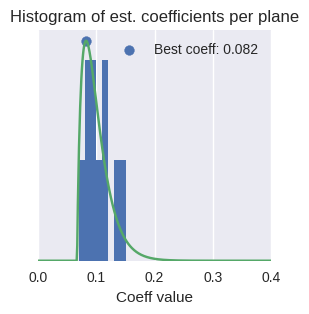

   Subtracting with estimated coefficient 0.082
         Subtracting plane 0 from 15
         Subtracting plane 1 from 16
         Subtracting plane 2 from 17
         Subtracting plane 3 from 18
         Subtracting plane 4 from 19
         Subtracting plane 5 from 20
         Subtracting plane 6 from 21
         Subtracting plane 7 from 22
         Subtracting plane 8 from 23
         Subtracting plane 9 from 24
         Subtracting plane 10 from 25
         Subtracting plane 11 from 26
         Subtracting plane 12 from 27
         Subtracting plane 13 from 28
         Subtracting plane 14 from 29
   Estimating fusing shifts


<tifffile.TiffFile 'Max30_500umdeep…_00001_00003.tif'> asarray failed to reshape (29580, 2414, 146) to (36000, 30, 2414, 146)


      Overriding
   Using best fuse shift of 1
   Building ops file
   Saved init mov to /mnt/md0/runs/s3d-Full-Demo-Coconut/summary/init_mov.npy
   Aligning planes
float64
70
      Fixing 9 plane alignment outliers
   Fusing and padding init mov
Setting smooth_sigma: 1.15
Setting maxregshift: 0.15
Setting Ly: 634
Setting Lx: 659
Setting nonrigid: True
   Computing reference images
        Computed reference for plane 0
        Computed reference for plane 1
        Computed reference for plane 2
        Computed reference for plane 3
        Computed reference for plane 4
        Computed reference for plane 5
        Computed reference for plane 6
        Computed reference for plane 7
        Computed reference for plane 8
        Computed reference for plane 9
        Computed reference for plane 10
        Computed reference for plane 11
        Computed reference for plane 12
        Computed reference for plane 13
        Computed reference for plane 14
        Computed referenc

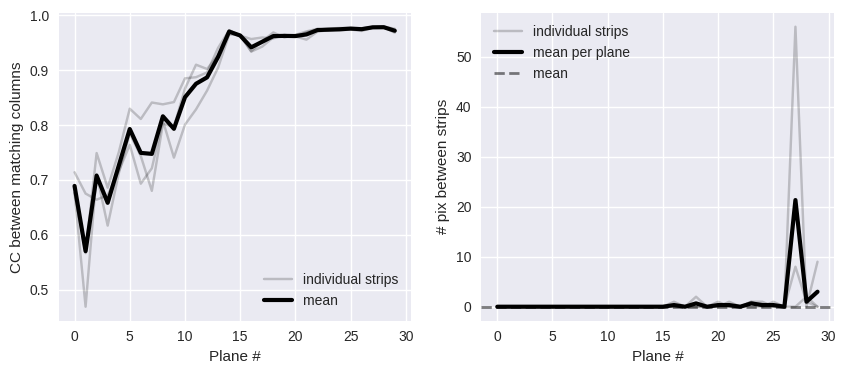

In [8]:
%%time
# This step only uses `n_init_files` files, so the  runtime will stay the same even with larger recordings
# soon this will also be gpu-ified to be faster!
job.run_init_pass()

In [9]:
summary = job.load_summary()

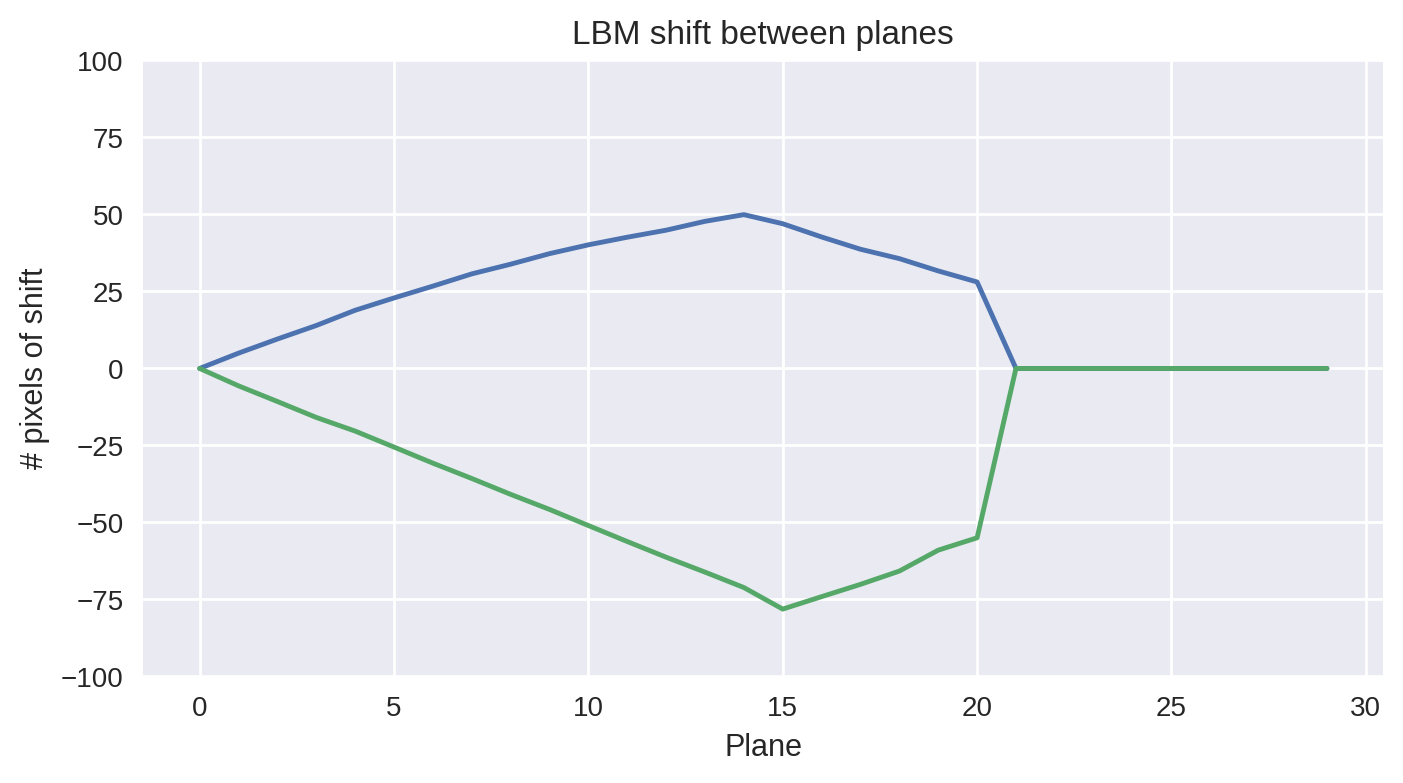

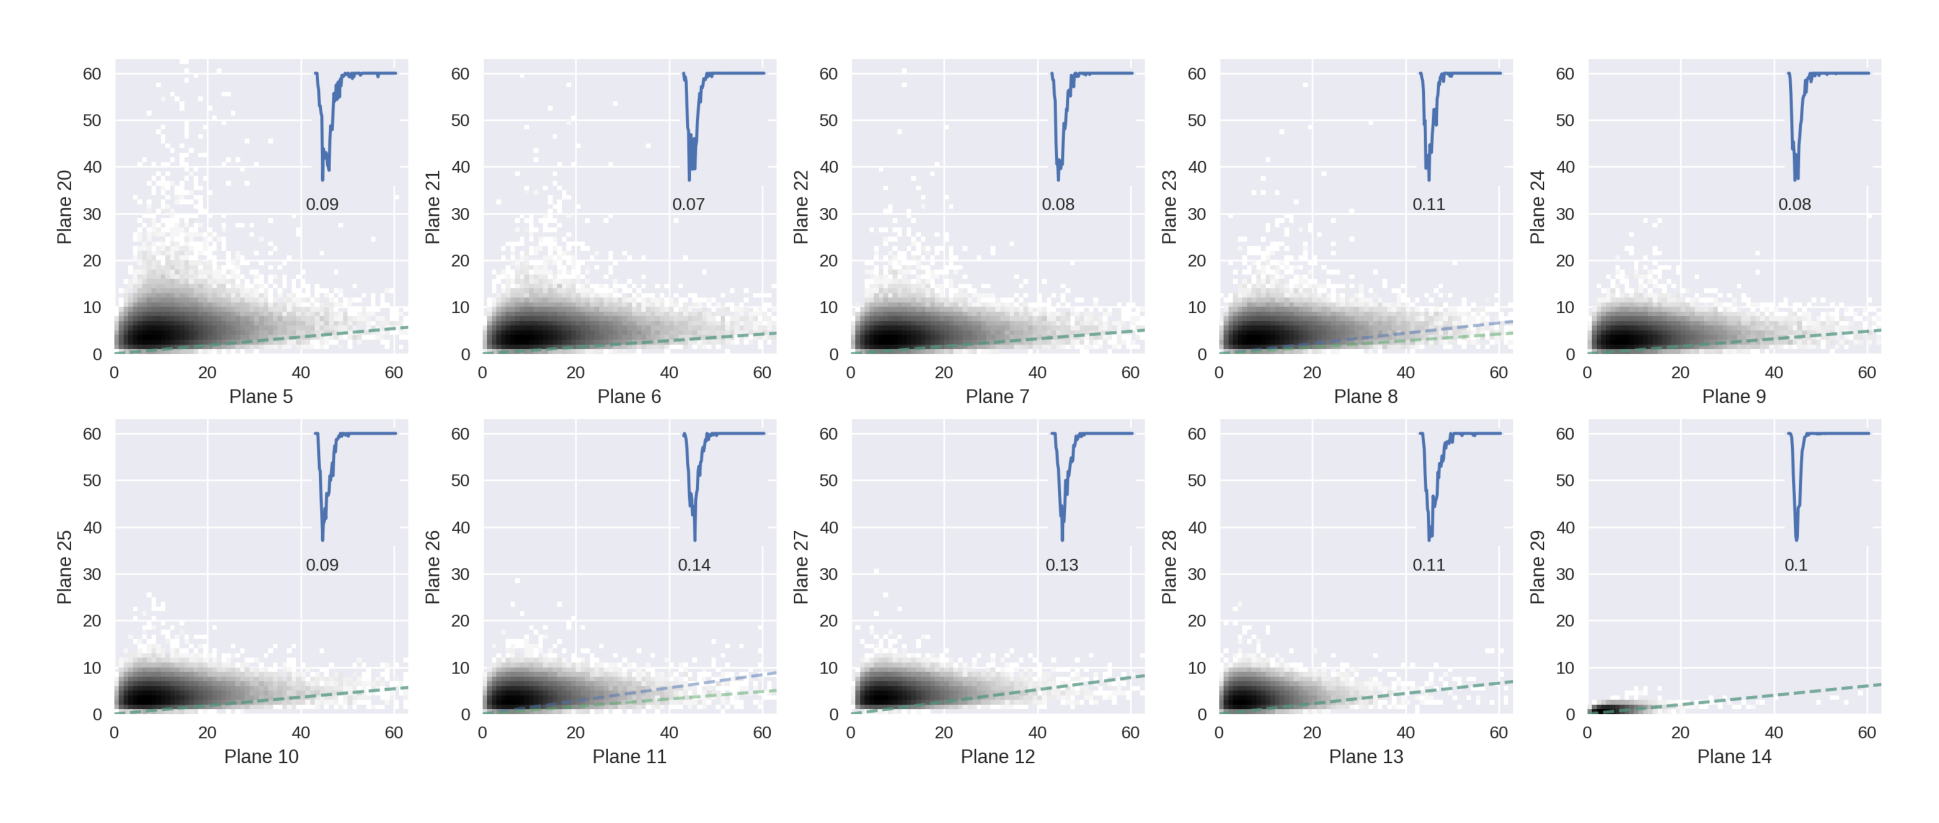

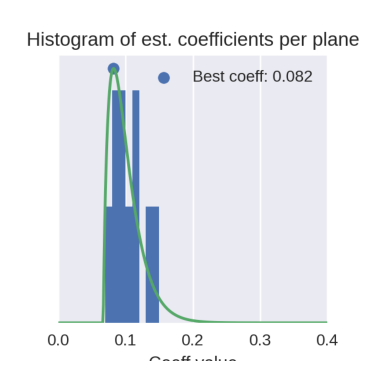

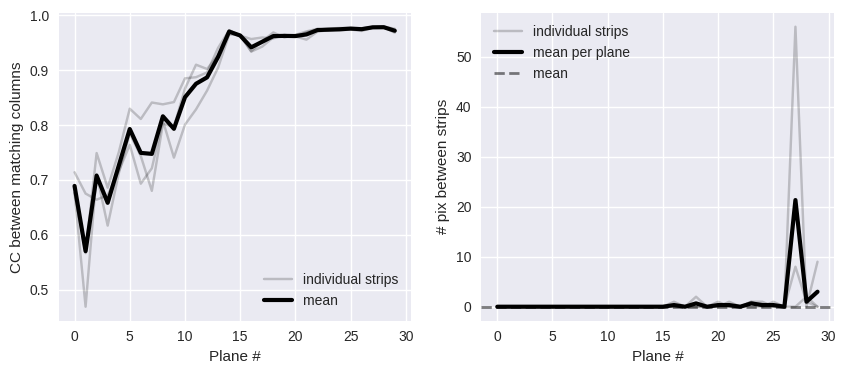

In [10]:
job.show_summary_plots()

## Registration
First, we do registration over time of the  xy-drift caused by brain movement. This is similar to Suite2P registratrion, it does rigid registration followed by non-rigid registration. This is accelerated on the GPU. Suite2P registration parameters can be changed, see `default_params.py` for a list of all parameters related to registration. After you have registered, you can load the registered fused movie into memory and take a look at the mean image. I suggest cropping the dark edges if you have any as shown in the cells below.

If you run out of gpu memory, try reducing the `gpu_reg_batchsize` parameter. I have a A4500 with 20GB memory which works well with a batchsize of 10.

In [11]:
# If you have large tiffs, split the large tiffs into files of size 100 after registration
job.params['split_tif_size'] = 100
job.params['gpu_reg_batchsize'] = 10

In [ ]:
%%time
job.register_gpu()

      Found dir /mnt/md0/runs/s3d-Full-Demo-Coconut/registered_fused_data with tag registered_fused_data
   Overriding fuse shift value to 1
Will analyze 5 tifs in 5 batches
   Enforcing positivity
   Launching IO thread
         Memory at batch 0.  Total Used: 113.440 GB, Virtual Available: 405.442 GB, Virtual Used: 097.754 GB, Swap Used: 015.686 GB
Loading Batch 0 of 4
      Loading /mnt/md0/data/Coconut/Max30_500umdeep_1p75by1p75mm_3umppix_9p86Hz_250mW_00001_00001.tif


<tifffile.TiffFile 'Max30_500umdeep…_00001_00001.tif'> asarray failed to reshape (29580, 2414, 146) to (36000, 30, 2414, 146)
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in a

   Loaded 1 files, total 18.79 GB
   Batch 0 IO thread joined
         Memory after IO thread joinTotal Used: 132.364 GB, Virtual Available: 386.517 GB, Virtual Used: 116.679 GB, Swap Used: 015.686 GB
         Memory after movie copied from threadTotal Used: 151.197 GB, Virtual Available: 367.685 GB, Virtual Used: 135.511 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 132.347 GB, Virtual Available: 386.534 GB, Virtual Used: 116.662 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 132.347 GB, Virtual Available: 386.534 GB, Virtual Used: 116.662 GB, Swap Used: 015.686 GB
      Loaded batch of size (30, 986, 584, 584)
      Sending frames 0-10 to GPU for rigid registration
      Loading /mnt/md0/data/Coconut/Max30_500umdeep_1p75by1p75mm_3umppix_9p86Hz_250mW_00001_00002.tif
         Loaded mov and masks to GPU for rigid reg in 0.52 sec
         Subtracting min pix vals to enforce positivity
       

<tifffile.TiffFile 'Max30_500umdeep…_00001_00002.tif'> asarray failed to reshape (29580, 2414, 146) to (36000, 30, 2414, 146)


   Non rigid transformed (on CPU) in 0.87 sec
         After GPU Batch:    Total Used: 158.575 GB, Virtual Available: 360.306 GB, Virtual Used: 142.890 GB, Swap Used: 015.686 GB
      Sending frames 60-70 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of shape 30, 10, 634, 659; 0.93 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.29 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.50 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Computed SNR and smoothed phase corrs in 4.80 sec


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


         Computed subpixel shifts in 0.74 sec
      Computed non-rigid shifts in 5.91 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.14 sec
   Non rigid transformed (on CPU) in 1.66 sec
         After GPU Batch:    Total Used: 219.594 GB, Virtual Available: 299.288 GB, Virtual Used: 203.908 GB, Swap Used: 015.686 GB
      Sending frames 140-150 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 1.82 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of shape 30, 10, 634, 659; 0.93 GB
         Allocating memory for shifted movie
         Registered batch in 0.03 sec
         Shifted batch in 0.11 sec
         Freeing all blocks
      Completed rigid registration in 1.97 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phas

         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.29 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.49 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.84 sec
         After GPU Batch:    Total Used: 201.351 GB, Virtual Available: 317.531 GB, Virtual Used: 185.665 GB, Swap Used: 015.686 GB
      Sending frames 220-230 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.03 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.29 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.50 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.88 sec
         After GPU Batch:    Total Used: 168.896 GB, Virtual Available: 349.986 GB, Virtual Used: 153.210 GB, Swap Used: 015.686 GB
      Sending frames 300-310 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.28 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.49 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.86 sec
         After GPU Batch:    Total Used: 172.648 GB, Virtual Available: 346.234 GB, Virtual Used: 156.962 GB, Swap Used: 015.686 GB
      Sending frames 380-390 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.14 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.28 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.13 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.49 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.83 sec
         After GPU Batch:    Total Used: 176.469 GB, Virtual Available: 342.413 GB, Virtual Used: 160.783 GB, Swap Used: 015.686 GB
      Sending frames 460-470 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.14 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.28 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.48 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.82 sec
         After GPU Batch:    Total Used: 180.214 GB, Virtual Available: 338.667 GB, Virtual Used: 164.529 GB, Swap Used: 015.686 GB
      Sending frames 540-550 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.29 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.50 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.84 sec
         After GPU Batch:    Total Used: 183.981 GB, Virtual Available: 334.901 GB, Virtual Used: 168.295 GB, Swap Used: 015.686 GB
      Sending frames 620-630 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.03 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.29 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.50 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.83 sec
         After GPU Batch:    Total Used: 187.723 GB, Virtual Available: 331.159 GB, Virtual Used: 172.037 GB, Swap Used: 015.686 GB
      Sending frames 700-710 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.28 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.49 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.81 sec
         After GPU Batch:    Total Used: 191.482 GB, Virtual Available: 327.399 GB, Virtual Used: 175.797 GB, Swap Used: 015.686 GB
      Sending frames 780-790 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.28 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.49 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.83 sec
         After GPU Batch:    Total Used: 195.234 GB, Virtual Available: 323.647 GB, Virtual Used: 179.549 GB, Swap Used: 015.686 GB
      Sending frames 860-870 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.28 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.49 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.81 sec
         After GPU Batch:    Total Used: 198.983 GB, Virtual Available: 319.898 GB, Virtual Used: 183.298 GB, Swap Used: 015.686 GB
      Sending frames 940-950 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Memory after movie copied from threadTotal Used: 201.039 GB, Virtual Available: 317.843 GB, Virtual Used: 185.353 GB, Swap Used: 015.686 GB
         Memory after thread memory clearedTotal Used: 182.211 GB, Virtual Available: 336.671 GB, Virtual Used: 166.525 GB, Swap Used: 015.686 GB
   Launching IO thread for next batch
      Loading /mnt/md0/data/Coconut/Max30_500umdeep_1p75by1p75mm_3umppix_9p86Hz_250mW_00001_00003.tif
         After IO thread launch:Total Used: 182.211 GB, Virtual Available: 336.671 GB, Virtual Used: 166.525 GB, Swap Used: 015.686 GB
      Loaded batch of size (30, 986, 584, 584)
      Sending frames 0-10 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.18 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of shape 30, 10, 634, 659; 0.93 GB
         Allocating memory for shifted movie
         Registered batch in 0.11 sec
         Shi

         Registered batch in 0.03 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.29 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.50 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec


<tifffile.TiffFile 'Max30_500umdeep…_00001_00003.tif'> asarray failed to reshape (29580, 2414, 146) to (36000, 30, 2414, 146)


   Non rigid transformed (on CPU) in 0.81 sec
         After GPU Batch:    Total Used: 205.766 GB, Virtual Available: 313.116 GB, Virtual Used: 190.080 GB, Swap Used: 015.686 GB
      Sending frames 80-90 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of shape 30, 10, 634, 659; 0.93 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.28 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.49 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

         Registered batch in 4.70 sec
         Shifted batch in 5.59 sec
         Freeing all blocks
      Completed rigid registration in 10.45 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 10.67 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 6.47 sec
   Non rigid transformed (on CPU) in 1.36 sec
         After GPU Batch:    Total Used: 288.752 GB, Virtual Available: 230.130 GB, Virtual Used: 273.066 GB, Swap Used: 015.686 GB
      Sending frames 160-170 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 1.52 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mo

         Registered batch in 0.03 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.29 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.50 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 1.66 sec
         After GPU Batch:    Total Used: 250.411 GB, Virtual Available: 268.471 GB, Virtual Used: 234.725 GB, Swap Used: 015.686 GB
      Sending frames 240-250 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Allocating memory for shifted movie
         Registered batch in 0.03 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.33 sec
         Allocated GPU array for non-rigid reg in 0.09 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.56 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.15 sec
   Non rigid transformed (on CPU) in 1.02 sec
         After GPU Batch:    Total Used: 216.355 GB, Virtual Available: 302.527 GB, Virtual Used: 200.669 GB, Swap Used: 015.686 GB
      Sending frames 320-330 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.18 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
  

         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.29 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.13 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.50 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.84 sec
         After GPU Batch:    Total Used: 220.126 GB, Virtual Available: 298.755 GB, Virtual Used: 204.441 GB, Swap Used: 015.686 GB
      Sending frames 400-410 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.29 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.50 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.83 sec
         After GPU Batch:    Total Used: 223.886 GB, Virtual Available: 294.996 GB, Virtual Used: 208.200 GB, Swap Used: 015.686 GB
      Sending frames 480-490 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.16 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.28 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.49 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.83 sec
         After GPU Batch:    Total Used: 227.630 GB, Virtual Available: 291.252 GB, Virtual Used: 211.944 GB, Swap Used: 015.686 GB
      Sending frames 560-570 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.28 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.49 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.83 sec
         After GPU Batch:    Total Used: 231.405 GB, Virtual Available: 287.476 GB, Virtual Used: 215.720 GB, Swap Used: 015.686 GB
      Sending frames 640-650 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.28 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.49 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.82 sec
         After GPU Batch:    Total Used: 235.158 GB, Virtual Available: 283.724 GB, Virtual Used: 219.472 GB, Swap Used: 015.686 GB
      Sending frames 720-730 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.28 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.49 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.80 sec
         After GPU Batch:    Total Used: 238.908 GB, Virtual Available: 279.973 GB, Virtual Used: 223.223 GB, Swap Used: 015.686 GB
      Sending frames 800-810 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.29 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.13 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.49 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.79 sec
         After GPU Batch:    Total Used: 242.650 GB, Virtual Available: 276.231 GB, Virtual Used: 226.965 GB, Swap Used: 015.686 GB
      Sending frames 880-890 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.28 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.49 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.80 sec
         After GPU Batch:    Total Used: 246.398 GB, Virtual Available: 272.484 GB, Virtual Used: 230.712 GB, Swap Used: 015.686 GB
      Sending frames 960-970 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.14 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.03 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.29 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.49 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.87 sec
         After GPU Batch:    Total Used: 188.140 GB, Virtual Available: 330.742 GB, Virtual Used: 172.454 GB, Swap Used: 015.686 GB
      Sending frames 20-30 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of

<tifffile.TiffFile 'Max30_500umdeep…_00001_00004.tif'> asarray failed to reshape (29580, 2414, 146) to (36000, 30, 2414, 146)


   Non rigid transformed (on CPU) in 0.86 sec
         After GPU Batch:    Total Used: 206.623 GB, Virtual Available: 312.258 GB, Virtual Used: 190.938 GB, Swap Used: 015.686 GB
      Sending frames 80-90 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.14 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of shape 30, 10, 634, 659; 0.93 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.28 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.49 sec

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

   Non rigid transformed (on CPU) in 11.84 sec
         After GPU Batch:    Total Used: 240.535 GB, Virtual Available: 278.346 GB, Virtual Used: 224.850 GB, Swap Used: 015.686 GB
      Sending frames 150-160 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.18 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of shape 30, 10, 634, 659; 0.93 GB
         Allocating memory for shifted movie
         Registered batch in 0.03 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.08 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 

         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.49 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.85 sec
         After GPU Batch:    Total Used: 245.051 GB, Virtual Available: 273.830 GB, Virtual Used: 229.366 GB, Swap Used: 015.686 GB
      Sending frames 230-240 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of shape 30, 10, 634, 659; 0.93 GB
         Allocating memory for shifted movie
         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.29 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phas

         Allocated GPU array for non-rigid reg in 0.09 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.57 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.16 sec
   Non rigid transformed (on CPU) in 1.05 sec
         After GPU Batch:    Total Used: 215.840 GB, Virtual Available: 303.042 GB, Virtual Used: 200.154 GB, Swap Used: 015.686 GB
      Sending frames 310-320 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.18 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov of shape 30, 10, 634, 659; 0.93 GB
         Allocating memory for shifted movie
         Registered batch in 0.03 sec
         Shifted batch in 0.10

         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.28 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.49 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.83 sec
         After GPU Batch:    Total Used: 219.588 GB, Virtual Available: 299.294 GB, Virtual Used: 203.902 GB, Swap Used: 015.686 GB
      Sending frames 390-400 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.03 sec
         Shifted batch in 0.13 sec
         Freeing all blocks
      Completed rigid registration in 0.32 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.14 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.54 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.83 sec
         After GPU Batch:    Total Used: 223.345 GB, Virtual Available: 295.537 GB, Virtual Used: 207.659 GB, Swap Used: 015.686 GB
      Sending frames 470-480 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.28 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.49 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.84 sec
         After GPU Batch:    Total Used: 227.104 GB, Virtual Available: 291.778 GB, Virtual Used: 211.418 GB, Swap Used: 015.686 GB
      Sending frames 550-560 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.28 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.49 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.82 sec
         After GPU Batch:    Total Used: 230.852 GB, Virtual Available: 288.030 GB, Virtual Used: 215.166 GB, Swap Used: 015.686 GB
      Sending frames 630-640 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.14 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.28 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.49 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.81 sec
         After GPU Batch:    Total Used: 234.614 GB, Virtual Available: 284.267 GB, Virtual Used: 218.929 GB, Swap Used: 015.686 GB
      Sending frames 710-720 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.28 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.49 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.81 sec
         After GPU Batch:    Total Used: 238.370 GB, Virtual Available: 280.511 GB, Virtual Used: 222.685 GB, Swap Used: 015.686 GB
      Sending frames 790-800 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.14 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.28 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.49 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.81 sec
         After GPU Batch:    Total Used: 242.109 GB, Virtual Available: 276.773 GB, Virtual Used: 226.423 GB, Swap Used: 015.686 GB
      Sending frames 870-880 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.14 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

         Registered batch in 0.02 sec
         Shifted batch in 0.10 sec
         Freeing all blocks
      Completed rigid registration in 0.28 sec
         Allocated GPU array for non-rigid reg in 0.07 sec
   Clipped movie in 0.00 sec
   Split movie into blocks in 0.00 sec
   Completed FFT of blocks and computed phase correlations in 0.00 sec
   Computed SNR and smoothed phase corrs in 0.12 sec
         Computed subpixel shifts in 0.00 sec
      Computed non-rigid shifts in 0.49 sec
      Transferred shifted mov of shape (10, 30, 634, 659) to CPU in 0.12 sec
   Non rigid transformed (on CPU) in 0.83 sec
         After GPU Batch:    Total Used: 245.950 GB, Virtual Available: 272.931 GB, Virtual Used: 230.264 GB, Swap Used: 015.686 GB
      Sending frames 950-960 to GPU for rigid registration
         Loaded mov and masks to GPU for rigid reg in 0.15 sec
         Subtracting min pix vals to enforce positivity
         Subtracting crosstalk
         Fusing and padding movie
         Mov 

In [ ]:
offsets = job.load_registration_results()

In [ ]:
mov_full = job.get_registered_movie('registered_fused_data','f')
im_full = mov_full[:,:300].mean(axis=1).compute()

In [ ]:
# find crop values that minimize dark zones - check planes 0 and 15 in the following cell to 
# make sure you're not cutting out parts of the brain
# crop = ((0,18), (100,500), (100, 500))
crop = ((0,18), (None,None), (None, None))

In [ ]:
f,ax,__  = tfu.show_tif(im_full[0,crop[1][0]:crop[1][1], crop[2][0]:crop[2][1]])
# tfu.show_tif(im_full[15,crop[1][0]:crop[1][1], crop[2][0]:crop[2][1]])
ax.axis('off')

In [ ]:
f,ax,__  = tfu.show_tif(im_full[3,crop[1][0]:crop[1][1], crop[2][0]:crop[2][1]])
# tfu.show_tif(im_full[15,crop[1][0]:crop[1][1], crop[2][0]:crop[2][1]])
ax.axis('off')

In [ ]:
f,ax,__  = tfu.show_tif(im_full[18,crop[1][0]:crop[1][1], crop[2][0]:crop[2][1]])
# tfu.show_tif(im_full[15,crop[1][0]:crop[1][1], crop[2][0]:crop[2][1]])
ax.axis('off')

In [ ]:
f,ax,__  = tfu.show_tif(im_full[15,crop[1][0]:crop[1][1], crop[2][0]:crop[2][1]])
# tfu.show_tif(im_full[15,crop[1][0]:crop[1][1], crop[2][0]:crop[2][1]])
ax.axis('off')

In [ ]:
import datetime

In [ ]:
x0 = datetime.datetime.strptime('2023-09-28 12:20:00', '%Y-%m-%d %H:%M:%S')
x1 = datetime.datetime.strptime('2023-09-28 13:00:00', '%Y-%m-%d %H:%M:%S')

In [ ]:
f,ax = job.plot_memory_usage()
plt.xlim(x0,x1)
